In [1]:
print(__doc__)

# Common imports
import numpy as np
import numpy.random as rnd
import os
import pandas as pd

# File specific imports
import datetime
from dateutil.relativedelta import relativedelta

# To make this notebook's output stable across runs
rnd.seed(42)

# Show all columns when displaying dataframes
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


In [3]:
csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/DIAGNOSES_ICD.csv'
cols_to_keep = ['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']
diagnoses = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/D_ICD_DIAGNOSES.csv'
cols_to_keep = ['ICD9_CODE', 'SHORT_TITLE']
dir_diagnoses = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/ADMISSIONS.csv'
cols_to_keep = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_LOCATION', 'ETHNICITY', 'DIAGNOSIS']
admissions = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/PATIENTS.csv'
cols_to_keep = ['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']
patients = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/INPUTEVENTS_CV.csv'
cols_to_keep = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ORDERID', 'CHARTTIME', 'ITEMID', 'AMOUNT', 'AMOUNTUOM', 'ORIGINALAMOUNT', 'ORIGINALAMOUNTUOM', 'ORIGINALRATE', 'ORIGINALRATEUOM', 'RATE', 'RATEUOM'] # 'RATE', 'RATEUOM', 'STOPPED' are full of NaN
inputevents_cv = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/INPUTEVENTS_MV.csv'
cols_to_keep = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ORDERID', 'STARTTIME', 'ENDTIME', 'ITEMID', 'AMOUNT', 'AMOUNTUOM', 'RATE', 'RATEUOM', 'ORDERCATEGORYNAME', 'ORDERCATEGORYDESCRIPTION']
inputevents_mv = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/LABEVENTS.csv'
cols_to_keep = ['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM', 'VALUEUOM', 'FLAG'] # 'HADM_ID' is full of NaN
labevents = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/D_ITEMS.csv'
cols_to_keep = ['ITEMID', 'LABEL'] #'CATEGORY', 'UNITNAME', 'PARAM_TYPE' are full of NaN
d_items = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

csv_path = '/media/bigdatabuffalo/drive/MIMIC3/CSV/D_LABITEMS.csv'
cols_to_keep = ['ITEMID', 'LABEL', 'FLUID', 'CATEGORY']
d_labitems = pd.read_csv(csv_path, skipinitialspace = True, usecols = cols_to_keep)

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,9,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
admissions = admissions.applymap(str)
patients = patients.applymap(str)
inputevents_cv = inputevents_cv.applymap(str)
inputevents_mv  = inputevents_mv.applymap(str)
labevents  = labevents.applymap(str) 
d_items = d_items.applymap(str)
d_labitems = d_labitems.applymap(str)

# PATIENT INFORMATION

In [5]:
# Combine admissions and patients
patient_info = pd.merge(admissions, patients, on = ['SUBJECT_ID'])

# Change Ethnicity to White/Non-White
ethnicity = patient_info['ETHNICITY']

def get_ethnicity(value):
    if value == 'WHITE':
        return 'WHITE'
    else:
        return 'NOT WHITE'

list_ethnicity = [get_ethnicity(value) for value in ethnicity]

patient_info = patient_info.drop('ETHNICITY', axis = 1)
df_ethnicity = pd.DataFrame({'ETHNICITY' : list_ethnicity})
patient_info = pd.concat([patient_info, df_ethnicity], axis=1)

# Add ages
DoB = patient_info['DOB']
admDate = patient_info['ADMITTIME']

def get_age (birth, current):
    #replace dashes and colons with spaces to make breaking the string up easier
    birth = birth.replace('-', ' ')
    birth = birth.replace(':', ' ')
    current = current.replace('-', ' ')
    current = current.replace(':', ' ')

    #split into a string outputting [year, month, day, hour, minutes, seconds]
    birth = birth.split(' ')
    current = current.split(' ')

    #convert to integers
    birth = [int(i) for i in birth]
    current = [int(i) for i in current]
    
    #get age and return it
    birth = datetime.datetime(birth[0], birth[1], birth[2], birth[3], birth[4], birth[5])
    current = datetime.datetime(current[0], current[1], current[2], current[3], current[4], current[5])
    age = relativedelta(current, birth).years
    
    #adjust for 89+ category
    if age == 300:
        age = 89
    
    return age

def get_age_category(age):
    if age > 88:
        return ('89+')
    elif age > 60:
        return('Elderly')
    elif age > 50:
        return('50s')
    elif age > 40:
        return('40s')
    elif age > 30:
        return('30s')
    elif age > 17:
        return('20s')
    else:
        return('Child')

ages = []
age_categories = []

for i in range(len(DoB)):
    ages.append(get_age(DoB[i], admDate[i]))

for age in ages:
    age_categories.append(get_age_category(age))

ages_df = pd.DataFrame({'AGE' : ages})
ages_cat_df = pd.DataFrame({'AGE_CAT' : age_categories})
patient_info = pd.concat([patient_info, ages_df], axis=1)
patient_info = pd.concat([patient_info, ages_cat_df], axis=1)

# Add LOS
admDate = patient_info['ADMITTIME']
dischDate = patient_info['DISCHTIME']

def get_los (admit, disch):
    #replace dashes and colons with spaces to make breaking the string up easier
    admit = admit.replace('-', ' ')
    admit = admit.replace(':', ' ')
    disch = disch.replace('-', ' ')
    disch = disch.replace(':', ' ')

    #split into a string outputting [year, month, day, hour, minutes, seconds]
    admit = admit.split(' ')
    disch = disch.split(' ')

    #convert to integers
    admit = [int(i) for i in admit]
    disch = [int(i) for i in disch]
    
    #get los and return it
    admit = datetime.datetime(admit[0], admit[1], admit[2], admit[3], admit[4], admit[5])
    disch = datetime.datetime(disch[0], disch[1], disch[2], disch[3], disch[4], disch[5])
    los = (disch-admit).total_seconds()/3600
    los = round((los/24), 1)

    return los

los = []

for i in range(len(admDate)):
    los.append(get_los(admDate[i], dischDate[i]))
    
los_df = pd.DataFrame({'LOS' : los})
patient_info = pd.concat([patient_info, los_df], axis = 1)

# Get Day/Night (day is between 8 am : 8 pm)
admTime = patient_info['ADMITTIME']

def get_day_night (value):
    #replace dashes and colons with spaces to make breaking the string up easier
    value = value.replace('-', ' ')
    value = value.replace(':', ' ')
    
    #split into a string outputting [year, month, day, hour, minutes, seconds]
    date = value.split(' ')
    
    #leave hour/min/sec, convert to integers
    hour = date[3]
    int_hour = int(hour)
    
    #get day/night and return it
    if 7 < int_hour < 21:
        return 'DAY'
    else:
        return 'NIGHT'

day_night = [get_day_night(value) for value in admTime]

day_night_df = pd.DataFrame({'DAY_NIGHT' : day_night})
patient_info = pd.concat([patient_info, day_night_df], axis=1)

# Get admission day
admTime = patient_info['ADMITTIME']

def get_day_of_week (value):
    date = []
    int_date = []
    day_of_week = []
    
    #replace dashes and colons with spaces to make breaking the string up easier
    value = value.replace('-', ' ')
    value = value.replace(':', ' ')
    
    #split into a string outputting [year, month, day, hour, minutes, seconds]
    date = value.split(' ')
    
    #delete hour/min/sec, convert to integers
    del date[3:6]
    int_date = [int(i) for i in date]
    
    #get day of week and return it
    day_of_week = datetime.date(int_date[0], int_date[1], int_date[2]).weekday()
    
    return day_of_week


admTime_weekday = [get_day_of_week(value) for value in admTime]

weekday_data_df = pd.DataFrame({'ADM_DAY' : admTime_weekday})
patient_info = pd.concat([patient_info, weekday_data_df], axis=1)

# Clean up columns
patient_times_info = patient_info[['SUBJECT_ID', 'ADMITTIME', 'DISCHTIME', 'DOB']].copy()
patient_times_info = patient_times_info.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')

patient_info = patient_info.drop(['ADMITTIME', 'DISCHTIME', 'DOB'], axis = 1)

INPUTEVENTS

In [6]:
# Merge d_items onto inputevents_cv, and inputevents_mv separately
inputevents_cv = pd.merge(inputevents_cv, d_items, on = 'ITEMID')
inputevents_mv = pd.merge(inputevents_mv, d_items, on = 'ITEMID')

LABEVENTS

In [7]:
# Convert labevents[FLAG] : NaN to 0, abnomal to 1
labevents['FLAG'] = labevents['FLAG'].replace('nan', 0)
labevents['FLAG'] = labevents['FLAG'].replace('abnormal', 1)

# Merge d_labitems onto labevents 
labevents = pd.merge(labevents, d_labitems, on = 'ITEMID')

# Heparin Data Organization

In [8]:
patient_info.head()

,SUBJECT_ID,HADM_ID,ADMISSION_LOCATION,DIAGNOSIS,GENDER,EXPIRE_FLAG,ETHNICITY,AGE,AGE_CAT,LOS,DAY_NIGHT,ADM_DAY
0,22,165315,EMERGENCY ROOM ADMIT,BENZODIAZEPINE OVERDOSE,F,0,WHITE,64,Elderly,1.1,DAY,5
1,23,152223,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,M,0,WHITE,71,Elderly,5.5,NIGHT,0
2,23,124321,TRANSFER FROM HOSP/EXTRAM,BRAIN MASS,M,0,WHITE,75,Elderly,6.8,DAY,1
3,24,161859,TRANSFER FROM HOSP/EXTRAM,INTERIOR MYOCARDIAL INFARCTION,M,0,WHITE,39,30s,2.9,DAY,5
4,25,129635,EMERGENCY ROOM ADMIT,ACUTE CORONARY SYNDROME,M,0,WHITE,58,50s,3.5,NIGHT,6


1\. UNIQUE ADULTS

In [78]:
# Get only first ICU stay for each patient
patient_info = patient_info.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')

# Find all TPA patients
word_list = ['TPA', 'tpa']
tpa_cv = inputevents_cv.loc[inputevents_cv['LABEL'].isin(word_list)]
tpa_mv = inputevents_mv[inputevents_mv['LABEL'].str.contains('|'.join(word_list))]

# Clean up
tpa_mv['RATE'] = pd.to_numeric(tpa_mv['RATE']).round(decimals=1).astype(str)
tpa_cv = tpa_cv[tpa_cv.ORIGINALRATE != 'nan']
tpa_cv = tpa_cv[tpa_cv.AMOUNT != 'nan']
tpa_cv['ORIGINALRATE'] = pd.to_numeric(tpa_cv['ORIGINALRATE']).round(decimals=1).astype(str)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [79]:
# Count total patients recieving TPA
gp_cv = tpa_cv['SUBJECT_ID'].unique().tolist()
gp_mv = tpa_mv['SUBJECT_ID'].unique().tolist()
patient_count = len(gp_cv) + len(gp_mv)
print('Total PT recieving TPA: ', patient_count)

Total PT recieving TPA:  48


In [80]:
# Update patient_info to heparin_patients
patient_list = gp_cv + gp_mv

tpa_patients = pd.DataFrame({'SUBJECT_ID' : patient_list})
tpa_patients = tpa_patients.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')
tpa_patients = pd.merge(tpa_patients, patient_info, on = 'SUBJECT_ID')
tpa_patients.shape

(48, 12)

2\. aPTT MEASUREMENT

In [81]:
# Find all aPTT measurements
word_list = ['PTT']
aPTT = labevents[labevents['LABEL'].str.contains('|'.join(word_list))]
aPTT = aPTT.reset_index(drop = True)
aPTT['HADM_ID'] = aPTT['HADM_ID'].str.replace('.0', '')

# Remove repeat HADM_ID
word_list = tpa_patients['HADM_ID'].tolist()
aPTT = aPTT.loc[aPTT['HADM_ID'].isin(word_list)]

# Create Groups
gp_ptt = aPTT['SUBJECT_ID'].unique().tolist()
patient_count = len(gp_ptt)

print('Total PT with aPTT tests: ', patient_count)

Total PT with aPTT tests:  32


In [82]:
# Update tpa_patients
patient_list_ptt = gp_ptt
aPTT_patients = pd.DataFrame({'SUBJECT_ID' : patient_list_ptt})
tpa_patients = pd.merge(tpa_patients, aPTT_patients, on = 'SUBJECT_ID')
tpa_patients.shape

(32, 12)

In [83]:
ptts = aPTT['VALUE']

def get_aPTT(ptt):
    if ptt == '>150':
        return ('150.0')
    elif ptt == '>150.0':
        return ('150.0')
    elif ptt == '> 150':
        return ('150.0')
    elif len(ptt) > 5:
        return (None)
    elif ptt == 'ERROR':
        return (None)
    ptt = ptt.replace('..', '.')
    return(ptt)

def get_aPTT_category(ptt):
    if ptt == None:
        return (None)
    ptt = float(ptt)
    if ptt > 100:
        return ('SUPRA-TH')
    elif ptt < 60:
        return('SUB-TH')
    else:
        return('TH')

ptts_new = []
ptt_categories = []

for ptt in ptts:
    ptts_new.append(get_aPTT(ptt))

for ptt in ptts_new:
    ptt_categories.append(get_aPTT_category(ptt))

ptt_df = pd.DataFrame({'aPTT' : ptts_new})
ptt_cat_df = pd.DataFrame({'aPTT_CAT' : ptt_categories})

aPTT = aPTT.reset_index(drop = True)
aPTT = pd.concat([aPTT, ptt_df], axis = 1)
aPTT = pd.concat([aPTT, ptt_cat_df], axis = 1)
aPTT = aPTT[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'aPTT', 'VALUEUOM', 'LABEL', 'aPTT_CAT', 'FLUID', 'CATEGORY']].copy()

3\. NON TRANSFERS

In [84]:
tpa_patients = tpa_patients[tpa_patients.ADMISSION_LOCATION != 'TRANSFER FROM SKILLED NUR']
tpa_patients = tpa_patients[tpa_patients.ADMISSION_LOCATION != 'TRANSFER FROM HOSP/EXTRAM']
tpa_patients = tpa_patients[tpa_patients.ADMISSION_LOCATION != 'TRANSFER FROM OTHER HEALT']
tpa_patients = tpa_patients[tpa_patients.ADMISSION_LOCATION != '** INFO NOT AVAILABLE **']

tpa_patients.shape

(29, 12)

4\. FEATURES

Dosage Start Time

In [85]:
def get_length (first, second):
    #replace dashes and colons with spaces to make breaking the string up easier
    first = first.replace('-', ' ')
    first = first.replace(':', ' ')
    second = second.replace('-', ' ')
    second = second.replace(':', ' ')

    #split into a string outputting [year, month, day, hour, minutes, seconds]
    first = first.split(' ')
    second = second.split(' ')

    #convert to integers
    first = [int(i) for i in first]
    second = [int(i) for i in second]
    
    #get los and return it
    first = datetime.datetime(first[0], first[1], first[2], first[3], first[4], first[5])
    second = datetime.datetime(second[0], second[1], second[2], second[3], second[4], second[5])
    length = (second-first).total_seconds()/3600
    length = round(length, 1)

    return length

In [77]:
tpa_cv.head(10)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,ITEMID,AMOUNT,AMOUNTUOM,RATE,RATEUOM,ORDERID,ORIGINALAMOUNT,ORIGINALAMOUNTUOM,ORIGINALRATE,ORIGINALRATEUOM,LABEL,TOTALAMOUNT,ZERODATE
17202979,11684,172672,279134.0,2106-10-13 17:00:00,30135,50.0,mg,nan,nan,1422147,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11
17202980,11684,172672,279134.0,2106-10-13 23:00:00,30135,50.0,mg,nan,nan,6919093,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11
17202981,11684,172672,279134.0,2106-10-14 01:00:00,30135,100.0,mg,nan,nan,8799,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11
17202983,11684,172672,279134.0,2106-10-14 05:00:00,30135,50.0,mg,nan,nan,7009975,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11
17202984,11684,172672,279134.0,2106-10-14 06:00:00,30135,50.0,mg,nan,nan,4979678,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11
17202985,11684,172672,279134.0,2106-10-12 22:00:00,30135,25.0,mg,nan,nan,10082936,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11
17202986,11684,172672,279134.0,2106-10-13 22:00:00,30135,50.0,mg,nan,nan,6786745,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11
17202988,11684,172672,279134.0,2106-10-12 18:00:00,30135,0.0,mg,nan,nan,10227213,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11
17203025,11684,172672,279134.0,2106-10-14 08:00:00,30135,0.0,mg,nan,nan,2316850,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11
17203026,11684,172672,279134.0,2106-10-13 18:00:00,30135,50.0,mg,nan,nan,8353411,100.0,mg,50.0,ml/hr,TPA,850.0,1111-11-11 11:11:11


In [74]:
tpa_cv['ZERODATE'] = '1111-11-11 11:11:11'

In [76]:
startDate = tpa_cv['ZERODATE'].tolist()
endDate = tpa_cv['CHARTTIME'].tolist()

delta_list = []

for i in range(len(startDate)):
    delta_list.append(get_length(startDate[i], endDate[i]))
    
delta_df = pd.DataFrame({'order_TIME' : delta_list})
tpa_cv = tpa_mv.reset_index(drop = True)
tpa_cv = pd.concat([tpa_mv, delta_df], axis = 1)

In [86]:
# Update heparin dosage dataframes
word_list = tpa_patients['HADM_ID'].tolist()
tpa_cv['HADM_ID'] = tpa_cv['HADM_ID'].str.replace('.0', '')
tpa_cv = tpa_cv.loc[tpa_cv['HADM_ID'].isin(word_list)]
tpa_mv = tpa_mv.loc[tpa_mv['HADM_ID'].isin(word_list)]

# Sum of tPA recieved
tpa_cv['AMOUNT'] = pd.to_numeric(tpa_cv['AMOUNT']).round(decimals=1)
tpa_cv['TOTALAMOUNT'] = tpa_cv.groupby('SUBJECT_ID')['AMOUNT'].transform(sum)
tpa_mv['AMOUNT'] = pd.to_numeric(tpa_mv['AMOUNT']).round(decimals=1)
tpa_mv['TOTALAMOUNT'] = tpa_mv.groupby('SUBJECT_ID')['AMOUNT'].transform(sum)

# Total hours of tPA
# mv
startDate = tpa_mv['STARTTIME'].tolist()
endDate = tpa_mv['ENDTIME'].tolist()

delta_list = []

for i in range(len(startDate)):
    delta_list.append(get_length(startDate[i], endDate[i]))
    
delta_df = pd.DataFrame({'tPA_TIME' : delta_list})
tpa_mv = tpa_mv.reset_index(drop = True)
tpa_mv = pd.concat([tpa_mv, delta_df], axis = 1)
tpa_mv['tPA_LENGTH'] = tpa_mv.groupby('SUBJECT_ID')['tPA_TIME'].transform(sum)
tpa_mv = tpa_mv.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')
tpa_mv['tPA_RATE'] = tpa_mv['TOTALAMOUNT']/tpa_mv['tPA_LENGTH']
tpa_mv = tpa_mv[['SUBJECT_ID', 'HADM_ID', 'tPA_RATE', 'RATEUOM']]

# cv


In [34]:
# Extract IDs and Start Times
dose_cv = heparin_cv[['SUBJECT_ID', 'CHARTTIME']].copy()
dose_cv = dose_cv.rename(columns = {'CHARTTIME': 'DOSE_TIME'})

dose_mv = heparin_mv[['SUBJECT_ID', 'STARTTIME']].copy()
dose_mv = dose_mv.rename(columns = {'STARTTIME': 'DOSE_TIME'})

# Combine and take First Dose
dose_info = pd.concat([dose_cv, dose_mv])
first_dose = dose_info.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')

#Update patient numbers
x = heparin_cv['SUBJECT_ID'].unique().tolist()
y = heparin_mv['SUBJECT_ID'].unique().tolist()
z = x+y
z_df = pd.DataFrame({'SUBJECT_ID' : z})
z_df = z_df.drop_duplicates(subset = 'SUBJECT_ID', keep = 'first')
heparin_patients = pd.merge(heparin_patients, z_df, on = 'SUBJECT_ID')
print(heparin_patients.shape)
print ('Total patients with first dose: ', len(z))

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(2440, 12)
Total patients with first dose:  2440


MEASUREMENT TIME (dose to aPTT)

In [35]:
aPTT = aPTT.rename(columns = {'CHARTTIME': 'aPTT_TIME'})
measure_time = aPTT[['SUBJECT_ID', 'aPTT_TIME']].copy()
measure_time = pd.merge(measure_time, first_dose, on = 'SUBJECT_ID')

doseDate = measure_time['DOSE_TIME']
measureDate = measure_time['aPTT_TIME']

def get_length (first, second):
    #replace dashes and colons with spaces to make breaking the string up easier
    first = first.replace('-', ' ')
    first = first.replace(':', ' ')
    second = second.replace('-', ' ')
    second = second.replace(':', ' ')

    #split into a string outputting [year, month, day, hour, minutes, seconds]
    first = first.split(' ')
    second = second.split(' ')

    #convert to integers
    first = [int(i) for i in first]
    second = [int(i) for i in second]
    
    #get los and return it
    first = datetime.datetime(first[0], first[1], first[2], first[3], first[4], first[5])
    second = datetime.datetime(second[0], second[1], second[2], second[3], second[4], second[5])
    length = (second-first).total_seconds()/3600
    length = round(length, 1)

    return length

measure_list = []

for i in range(len(doseDate)):
    measure_list.append(get_length(doseDate[i], measureDate[i]))
    
measure_df = pd.DataFrame({'MEASURE_TIME' : measure_list})
measure_time = pd.concat([measure_time, measure_df], axis = 1)
measure_time.head()

,SUBJECT_ID,aPTT_TIME,DOSE_TIME,MEASURE_TIME
0,3,2101-10-22 04:30:00,2101-10-23 08:00:00,-27.5
1,3,2101-10-22 12:45:00,2101-10-23 08:00:00,-19.2
2,3,2101-10-22 21:15:00,2101-10-23 08:00:00,-10.8
3,3,2101-10-23 03:45:00,2101-10-23 08:00:00,-4.2
4,3,2101-10-23 10:10:00,2101-10-23 08:00:00,2.2


In [36]:
aPTT_dosage = pd.merge(aPTT, measure_time, on = ['SUBJECT_ID', 'aPTT_TIME'])

In [37]:
# Save rows with values between 4 and 10 hours
measurements = aPTT_dosage['MEASURE_TIME']

def get_measure (time):
    if time < 4:
        return (None)
    if time > 10:
        return (None)
    else:
        return (time)

measurements_list = [get_measure(value) for value in measurements]

measurements_df = pd.DataFrame({'MEASUREMENT_TIME' : measurements_list})
aPTT_dosage = pd.concat([aPTT_dosage, measurements_df], axis = 1)
aPTT_dosage = aPTT_dosage.dropna()
aPTT_dosage = aPTT_dosage.drop('MEASUREMENT_TIME', axis = 1)

DOSAGE TIME (adm to dose)

In [38]:
adm = patient_times_info[['SUBJECT_ID', 'ADMITTIME']].copy()
dosage_info = pd.merge(adm, first_dose, on = 'SUBJECT_ID')

admDate = dosage_info['ADMITTIME']
doseDate = dosage_info['DOSE_TIME']

dosage_list = []

for i in range(len(admDate)):
    dosage_list.append(get_length(admDate[i], doseDate[i]))
    
dosage_df = pd.DataFrame({'DOSAGE_TIME' : dosage_list})
dosage_time = pd.concat([dosage_info, dosage_df], axis = 1)
dosage_time.head()

,SUBJECT_ID,ADMITTIME,DOSE_TIME,DOSAGE_TIME
0,25,2160-11-02 02:06:00,2160-11-03 10:00:00,31.9
1,107,2115-02-20 17:41:00,2115-02-20 20:00:00,2.3
2,130,2119-10-29 14:49:00,2119-10-30 23:00:00,32.2
3,154,2117-12-29 21:36:00,2117-12-29 22:00:00,0.4
4,111,2142-04-24 06:55:00,2142-04-24 21:00:00,14.1


5\. STROKE PATIENTS

In [71]:
# Extract all ischemic stroke patients from heparin_patients
patient_diagnoses = pd.merge(diagnoses, dir_diagnoses, on = 'ICD9_CODE')
patient_diagnoses = patient_diagnoses.drop('ICD9_CODE', axis = 1)
patient_diagnoses['HADM_ID'] = patient_diagnoses['HADM_ID'].apply(str)
patient_diagnoses = patient_diagnoses.reset_index(drop = True)

word_list = ['STROKE', 'CVA', 'CEREBROVASCULAR ACCIDENT']
STROKE_diagnosis = heparin_patients[heparin_patients['DIAGNOSIS'].str.contains('|'.join(word_list))]
    #97 TOTAL STROKE

word_list = ['TIA', 'TRANSIENT ISCHEMIC ATTACK']
TIA_diagnosis = STROKE_diagnosis[STROKE_diagnosis['DIAGNOSIS'].str.contains('|'.join(word_list))]
    #53 TOTAL TIA
    
word_list = TIA_diagnosis['SUBJECT_ID'].tolist()
STROKE_diagnosis = STROKE_diagnosis.set_index(STROKE_diagnosis['SUBJECT_ID'])
ISCHEMIC_STROKE_diagnosis = STROKE_diagnosis.drop(word_list)
    #44 TOTAL ISCHEMIC STROKE

ISCHEMIC_STROKE_diagnosis['HADM_ID'].apply(str)
ISCHEMIC_STROKE_diagnosis = ISCHEMIC_STROKE_diagnosis.reset_index(drop = True)
word_list = ISCHEMIC_STROKE_diagnosis['HADM_ID'].tolist()
heparin_stroke_info = patient_diagnoses[patient_diagnoses['HADM_ID'].str.contains('|'.join(word_list))]
heparin_stroke_info = heparin_stroke_info.sort_values('SUBJECT_ID')

    # ISCHEMIC_STROKE_diagnosis contains general information about the patient's stay
    # heparin_stroke_info contains specific diagnoses about the patients (did not use)

In [76]:
aPTT_heparin = pd.merge(dosage_time, aPTT_dosage, on = ['SUBJECT_ID', 'DOSE_TIME'])
aPTT_heparin = pd.merge(ISCHEMIC_STROKE_diagnosis, aPTT_heparin, on = ['SUBJECT_ID', 'HADM_ID'])
aPTT_heparin = aPTT_heparin.drop(['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS', 'ADMITTIME', 'DOSE_TIME', 'ITEMID', 'aPTT_TIME', 'VALUEUOM', 'LABEL', 'FLUID', 'CATEGORY'], axis = 1)
aPTT_heparin.shape

(36, 13)

SPLIT WEEKDAY VS WEEKEND

In [77]:
# Split
word_list = ['0', '1', '2', '3']
heparin_weekday = aPTT_heparin.loc[aPTT_heparin['ADM_DAY'].isin(word_list)]

word_list = ['4', '5', '6']
heparin_weekend = aPTT_heparin.loc[aPTT_heparin['ADM_DAY'].isin(word_list)]

In [78]:
print(heparin_weekday.shape)
print(heparin_weekend.shape)

(24, 13)
(12, 13)


# Analysis

1\. WEEKDAY NUMERICAL : Target = MORTALITY

Univariate Analysis

In [79]:
# PREPROCESSING
from sklearn.preprocessing import normalize

# Scale numerical features
X_num_day = heparin_weekday[['LOS', 'DOSAGE_TIME', 'MEASURE_TIME']].copy()
scaled_X_num_day = pd.DataFrame(normalize(X_num_day), columns=X_num_day.keys())

# Combine numerical and categorical values
X_cat_day = heparin_weekday[['ADMISSION_LOCATION', 'GENDER', 'ETHNICITY', 'AGE_CAT', 'DAY_NIGHT', 'aPTT_CAT']].copy()
X_cat_day = pd.get_dummies(X_cat_day)
X_cat_day = X_cat_day.reset_index(drop = True)
X_num_day = pd.concat([scaled_X_num_day, X_cat_day], axis = 1)

X = X_num_day.as_matrix()

y_num_day = heparin_weekday[['EXPIRE_FLAG']].copy()
y = y_num_day.as_matrix()

column_titles = list(X_num_day)
value_map = []
for value in range(len(column_titles)):
    x = column_titles[value], value
    value_map.append(x)
value_map

[('LOS', 0),
 ('DOSAGE_TIME', 1),
 ('MEASURE_TIME', 2),
 ('ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE', 3),
 ('ADMISSION_LOCATION_EMERGENCY ROOM ADMIT', 4),
 ('ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI', 5),
 ('GENDER_F', 6),
 ('GENDER_M', 7),
 ('ETHNICITY_NOT WHITE', 8),
 ('ETHNICITY_WHITE', 9),
 ('AGE_CAT_50s', 10),
 ('AGE_CAT_89+', 11),
 ('AGE_CAT_Elderly', 12),
 ('DAY_NIGHT_DAY', 13),
 ('DAY_NIGHT_NIGHT', 14),
 ('aPTT_CAT_SUB-TH', 15),
 ('aPTT_CAT_SUPRA-TH', 16),
 ('aPTT_CAT_TH', 17)]

/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Container object of 18 artists>

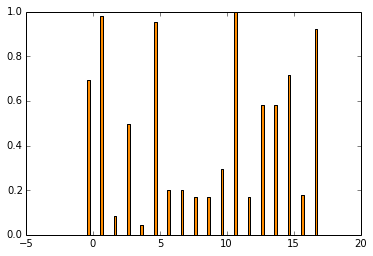

In [80]:
plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])

# Plot the feature score map
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')

In [81]:
# Show feature score map
score_map = []
for x in range(len(scores)):
    x = column_titles[x], scores[x]
    score_map.append(x)
score_map_df = pd.DataFrame(score_map)
score_map_df = score_map_df.rename(columns = {0: 'FEATURE', 1 : 'SCORE'})
score_map_df

,FEATURE,SCORE
0,LOS,0.694776
1,DOSAGE_TIME,0.978926
2,MEASURE_TIME,0.082685
3,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,0.497662
4,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,0.045010
5,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,0.955136
6,GENDER_F,0.202010
7,GENDER_M,0.202010
8,ETHNICITY_NOT WHITE,0.167510
9,ETHNICITY_WHITE,0.167510


In [82]:
pvalue_map = []
for x in range(len(selector.pvalues_)):
    x = column_titles[x], selector.pvalues_[x]
    pvalue_map.append(x)
pvalue_df = pd.DataFrame(pvalue_map)
pvalue_df = pvalue_df.rename(columns = {0: 'FEATURE', 1 : 'P-VALUE'})
pvalue_df

,FEATURE,P-VALUE
0,LOS,0.359636
1,DOSAGE_TIME,0.236712
2,MEASURE_TIME,0.885407
3,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,0.480694
4,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,0.935896
5,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,0.245147
6,GENDER_F,0.742787
7,GENDER_M,0.742787
8,ETHNICITY_NOT WHITE,0.781482
9,ETHNICITY_WHITE,0.781482


In [83]:
# SVM-ANOVA
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

print(X.shape)
y_list = y.tolist()
y_new = []
for i in range(len(y_list)):
    y_new.append(y_list[i][0])
y_array = np.array(y_new)
y_array.shape

score_means = list()
score_stds = list()
percentiles = percentiles = (1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y_array, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('')
plt.xlabel('Percentile')
plt.ylabel('Prediction Rate')

plt.axis('tight')
plt.show()

(24, 18)


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


ValueError: Found array with 0 feature(s) (shape=(15, 0)) while a minimum of 1 is required.

Multivariate Analysis